In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels 
import pywt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
import keras as ks


from tcn import TCN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import yaml
from pathlib import Path

from functions.denoising import *


# 0. Parameters

In [2]:
CONF = yaml.safe_load(Path('../config/config_tcn.yml').read_text())

# Threshold for Wavelet Denoising (from 0.0 to 1.0)
thresh = CONF['thresh']
# Get list of tickers
tickers = CONF['tickers']
#Wavelet Function
wavelet =  CONF['wavelet']
# Candle Stick Upsample Range (in minutes)
minute_sampling = CONF['minute_sampling']
# lookback subset to PACF pattern search
pacf_days_subset = CONF['pacf_days_subset']
# Number of hours to consider for 
# lag pattern lookup
nn_hours_pattern_lookup = CONF['nn_hours_pattern_lookup']
# Length of Subset Timeseries
subset_wavelet_transform = int(24*(60/minute_sampling)*pacf_days_subset) #60*hours # Number 
# Number of lags to analyse in Partial Autocorrelation Function
# 48 lags * 15 min_sampling / 60 hours per minute = 12 Hours in lags
lags_pacf = (60/minute_sampling)*nn_hours_pattern_lookup  

# Parameters Partial Autocorrelation Function
alpha_pacf = CONF['alpha_pacf']
method_pacf = CONF['method_pacf']

# Parameters for NN Model
epochs = CONF['epochs']
verbose = CONF['method_pacf']
n_features = CONF['n_features']
batch_size = CONF['batch_size']
test_size = CONF['test_size']
dilations = CONF['dilations']
kernel_size = CONF['kernel_size']
seed = CONF['seed']

In [3]:
print("Max lag to analyse is: ", lags_pacf)

Max lag to analyse is:  96.0


# 1. Data Import

In [4]:
df = pd.read_parquet('../data/Tensor_Portfolio.parquet')

# 2. Time series Denoising

In [5]:
dfs = []

for ticker in tickers:

    prices_return = df[df['Ticker'] == ticker]['Close_target_return_15m'].values

    # Get selected subset of data
    prices_return = prices_return[-subset_wavelet_transform:]

    # remove High Frequency Noise from Timeseries
    denoised_prices_return = wavelet_denoising(signal = prices_return, 
                  thresh = thresh,
                  wavelet = wavelet)

    # Get partial autocorrelation 
    pacf_values, confint = pacf(denoised_prices_return, 
                                nlags = lags_pacf, 
                                alpha = alpha_pacf, 
                                method = method_pacf)

    # Get deepest significant lag level
    max_lag_pacf = get_significant_max_lag_pacf(pacf_values = pacf_values,
                                confint = confint, 
                                lags_pacf = lags_pacf )

    print("For Ticker", ticker , 
    "the max significant autocorrelation is", 
    max_lag_pacf , " lag from", lags_pacf, " lags analyzed.")                            

    df_temp = pd.DataFrame()
    df_temp['price_returns'] = prices_return
    df_temp['denoised_price_returns'] = denoised_prices_return
    df_temp['ticker'] = ticker
    df_temp['pacf_lag'] = int(max_lag_pacf)

    dfs.append(df_temp)
    del df_temp
    
df_prices = pd.concat(dfs, ignore_index = True)

For Ticker ADAUSDT the max significant autocorrelation is 93.0  lag from 96.0  lags analyzed.
For Ticker BNBBTC the max significant autocorrelation is 75.0  lag from 96.0  lags analyzed.
For Ticker BNBUSDT the max significant autocorrelation is 96.0  lag from 96.0  lags analyzed.
For Ticker BTCUSDT the max significant autocorrelation is 94.0  lag from 96.0  lags analyzed.
For Ticker DOGEUSDT the max significant autocorrelation is 91.0  lag from 96.0  lags analyzed.
For Ticker EOSUSDT the max significant autocorrelation is 95.0  lag from 96.0  lags analyzed.
For Ticker ETCUSDT the max significant autocorrelation is 93.0  lag from 96.0  lags analyzed.
For Ticker ETHUSDT the max significant autocorrelation is 96.0  lag from 96.0  lags analyzed.
For Ticker IOTAUSDT the max significant autocorrelation is 96.0  lag from 96.0  lags analyzed.
For Ticker LTCUSDT the max significant autocorrelation is 93.0  lag from 96.0  lags analyzed.
For Ticker MKRUSDT the max significant autocorrelation is 9

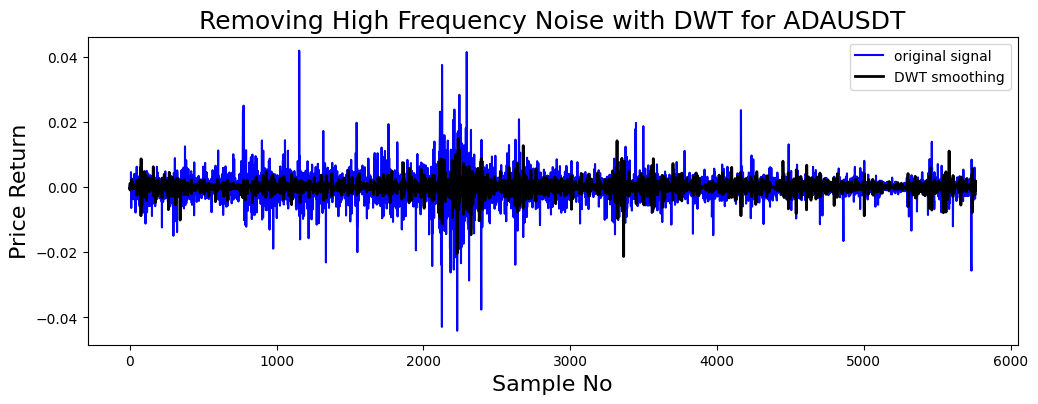

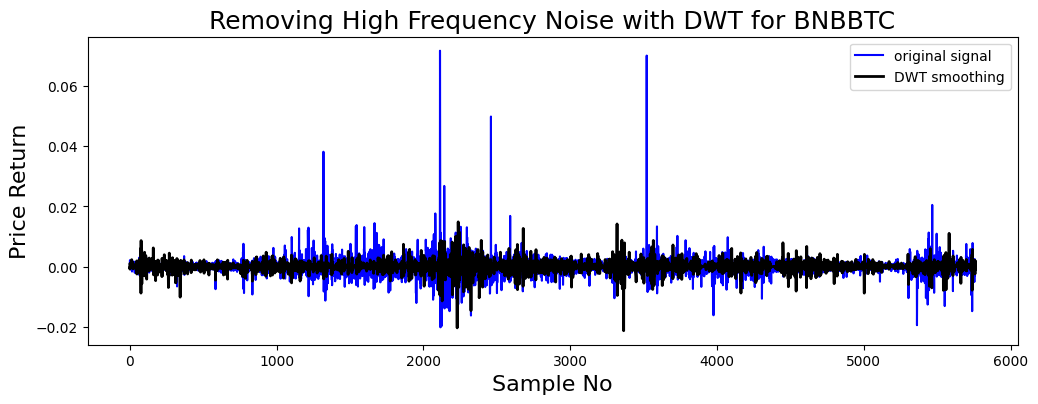

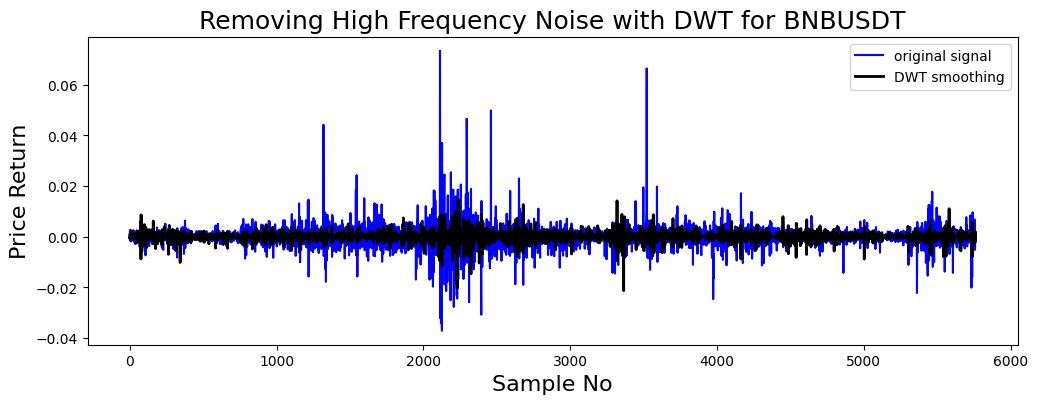

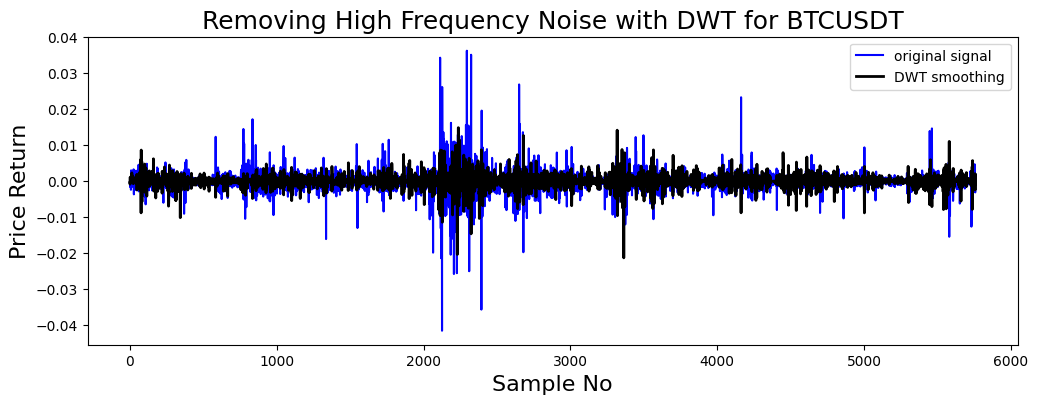

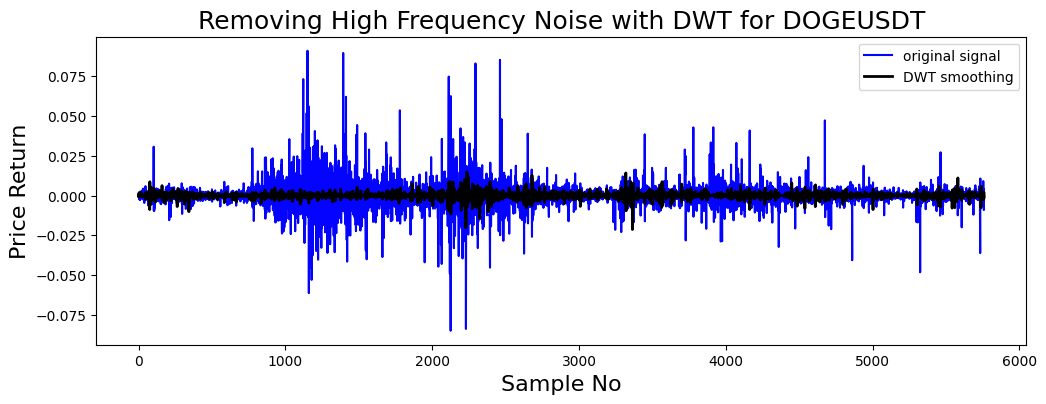

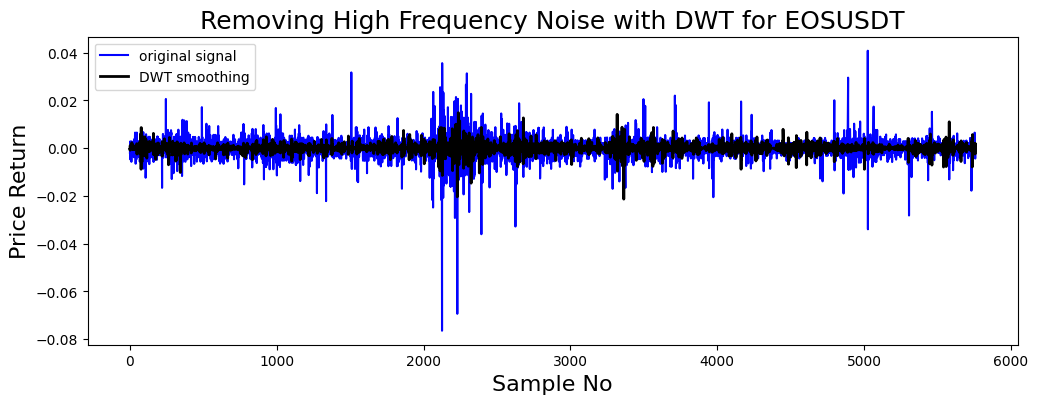

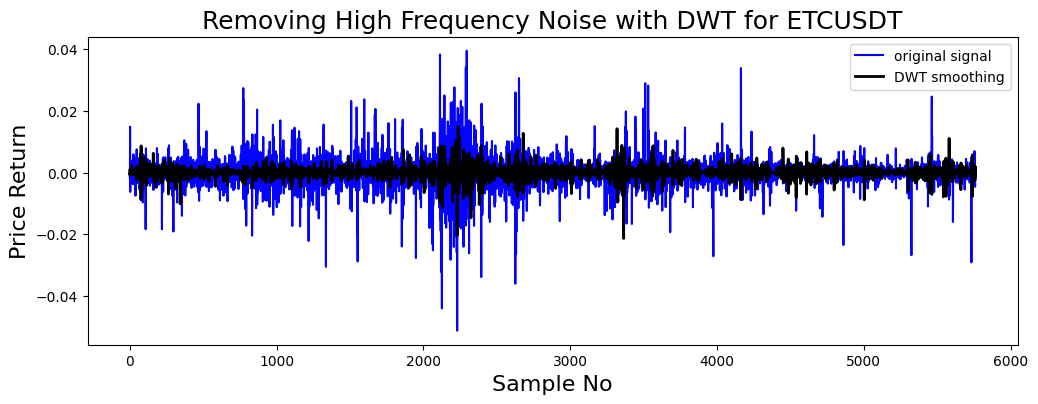

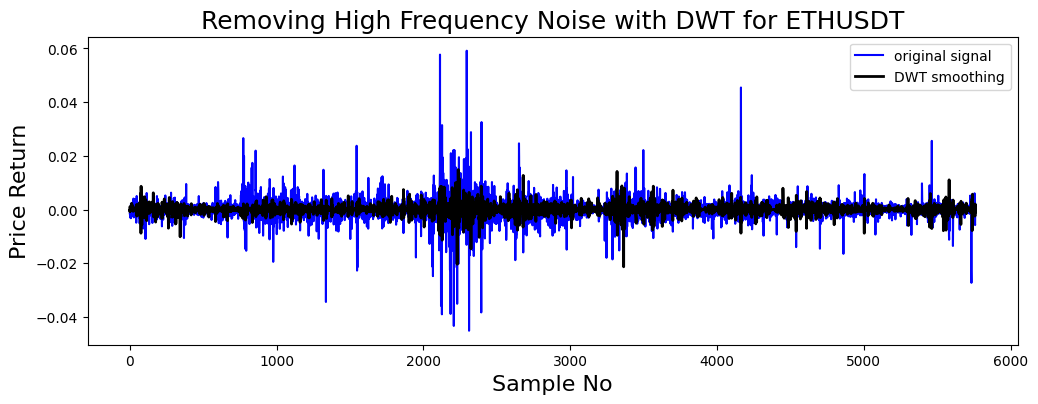

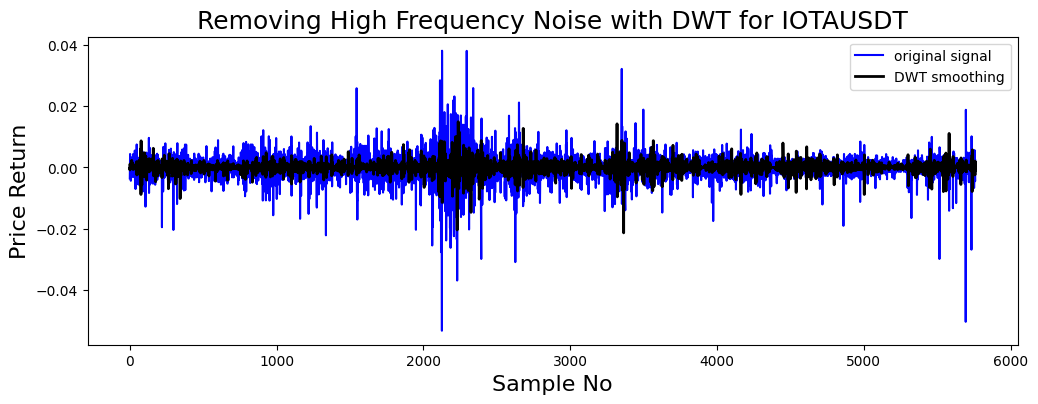

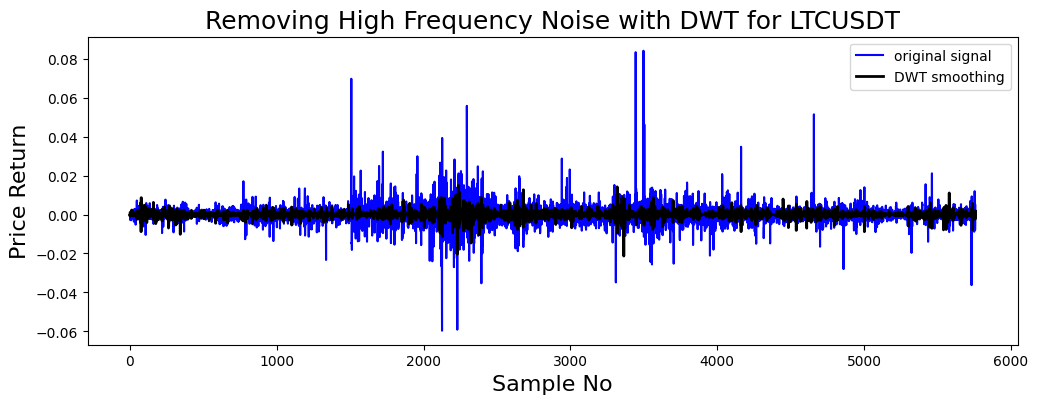

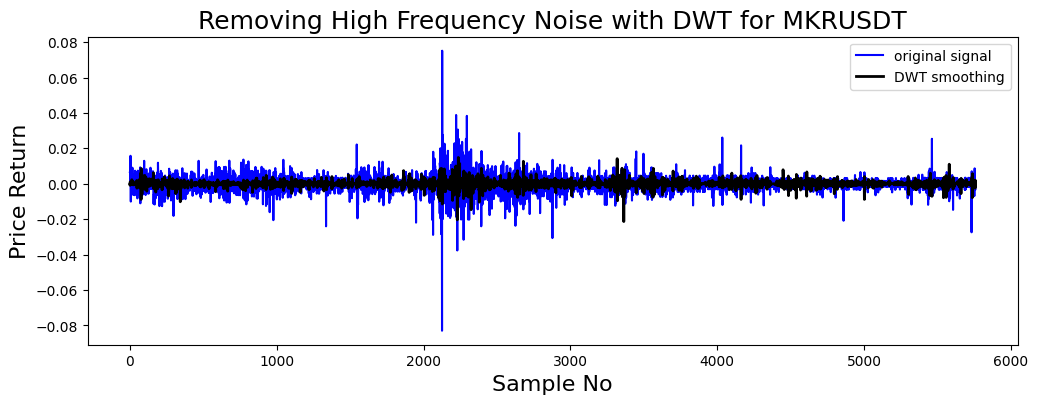

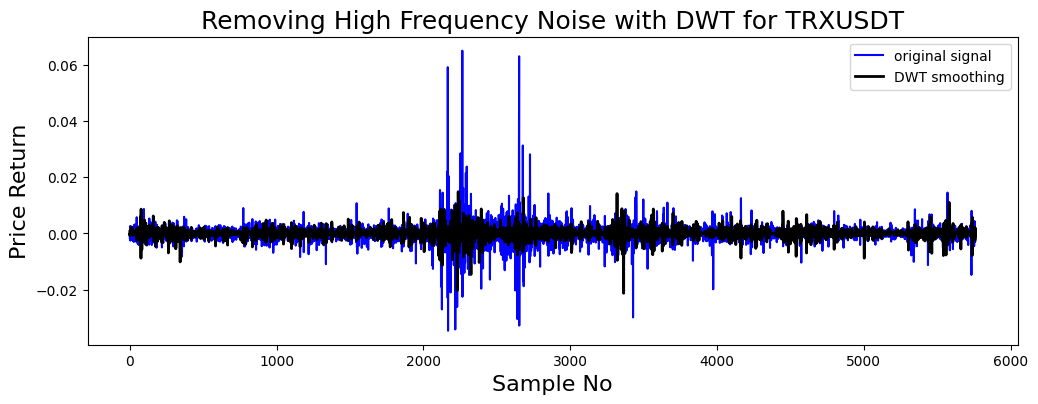

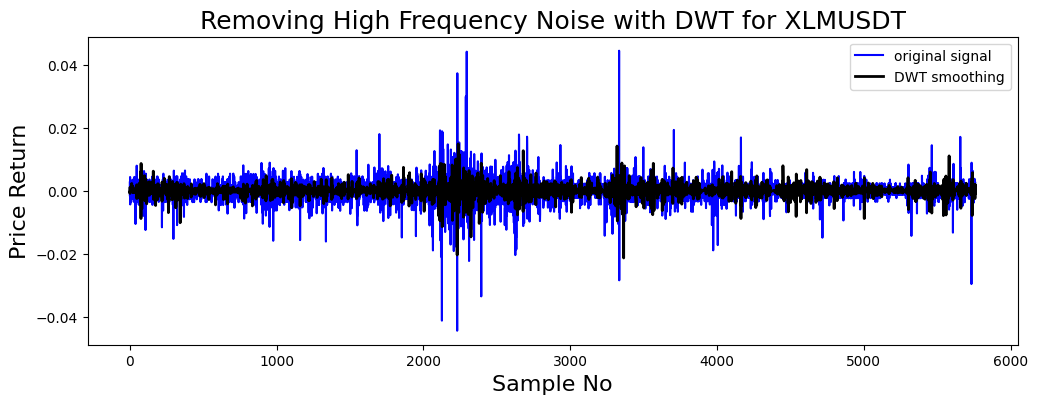

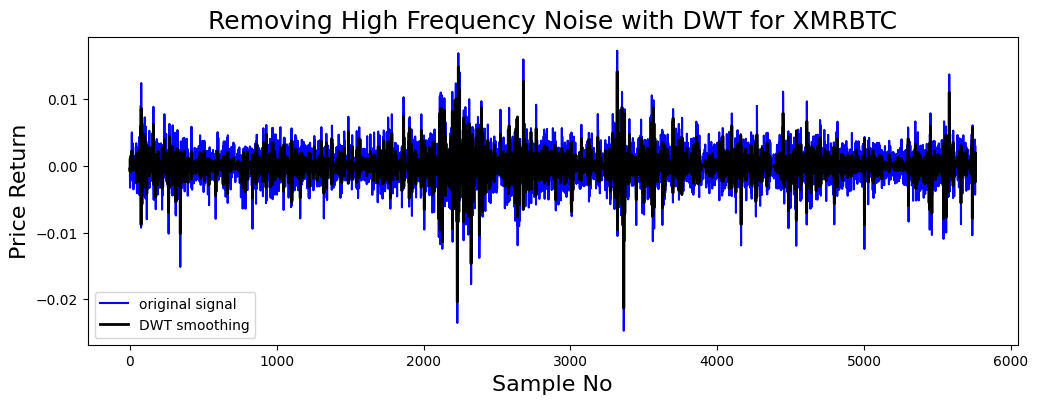

In [6]:
for ticker in df_prices['ticker'].unique():

    df_temp = df_prices[df_prices['ticker'] == ticker].copy()
    prices_return = df_temp['price_returns'].values
    denoised_price_returns = df_temp['denoised_price_returns'].values

    plot_reconstructed_signal(prices_return = prices_return, 
                            denoised_prices_return = denoised_prices_return, 
                            ticker = ticker )
    del df_temp

# 3. TCN Model

## 3.1 Training Using Self-made Timeseries batches

In [7]:
def test_train_batches(lag_length: int, 
                      ts_train : np.ndarray, 
                      ts_test: np.ndarray) -> list[np.ndarray]:
    """Get Test/Train batches for as Tensors

    Args:
        lag_length (int): _description_
        ts_train (np.ndarray): _description_
        ts_test (np.ndarray): _description_

    Returns:
        list[np.ndarray]: _description_
    """
    # 1-step-ahead forecast
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    for i in range(lag_length, len(ts_train)):
        X_train.append(ts_train[(i - lag_length):i])
        Y_train.append(ts_train[i])
        
    for i in range(lag_length, len(ts_test)): 
        X_test.append(ts_test[(i - lag_length):i])
        Y_test.append(ts_test[i])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    print(X_train.shape)
    print(Y_train.shape)
    print()
    print(X_test.shape)
    print(Y_test.shape)

    return X_train, Y_train, X_test, Y_test

In [8]:
def train_tcn_model(X_train : np.ndarray, 
                Y_train : np.ndarray, 
                X_test : np.ndarray, 
                Y_test: np.ndarray, 
                lag_length : int, 
                epochs: int, 
                verbose : int, 
                n_features: int, 
                seed : int, 
                dilations : list[int], 
                kernel_size : int):

    ks.utils.set_random_seed(123)
    model = Sequential()
    model.add(TCN(input_shape=(lag_length, n_features),
            dilations = dilations,
            kernel_size = kernel_size,
            use_skip_connections=True,
            use_batch_norm=False,
            use_weight_norm=False,
            use_layer_norm=False
            ))
    model.add(Dense(2, activation='linear')) 
    model.add(Dense(1, activation='linear')) # https://keras.io/api/layers/activations/
    model.compile(optimizer='adam', loss='mse')

    # Define Early stopping
    early_stop = EarlyStopping(monitor='val_loss',patience=5)

    print('Train...')
    # fit model
    model.fit(X_train, Y_train,
                epochs=epochs,
                validation_data = (X_test, Y_test),
                callbacks=[early_stop], 
                verbose = verbose)
                
    model.summary()

    return model

In [11]:
dfs_train = []
dfs_test = []
dfs_metric = []

for ticker in df_prices['ticker'].unique():
    
    print("Training model for ticker ", ticker)

    df_temp = df_prices[df_prices['ticker'] == ticker].copy()

    ts = df_temp['denoised_price_returns'].values.reshape(-1, 1)
    
    # Take the max divisible units of the timeseries
    # which can be generated by the selected batch_size
    lag_length = df_temp['pacf_lag'].values[0]
    max_len = int(len(ts)/lag_length) *lag_length
    ts = ts[-max_len:]

    scaler = StandardScaler()
    ts_norm = scaler.fit_transform(ts)

    test_units = int(len(ts) * test_size)
    test_start = int(len(ts) - test_units)

    ts_train = ts_norm[:test_start]
    ts_test = ts_norm[test_start:]

    X_train, Y_train, X_test, Y_test = test_train_batches(lag_length =lag_length, 
                                    ts_train = ts_train, 
                                    ts_test = ts_test)

    model = train_tcn_model(X_train = X_train, 
                Y_train = Y_train, 
                X_test = X_test, 
                Y_test = Y_test,
                lag_length = lag_length, 
                epochs = epochs, 
                verbose = verbose, 
                n_features = n_features, 
                seed = seed, 
                dilations = dilations, 
                kernel_size = kernel_size)               

    forecast_train = scaler.inverse_transform(model.predict(X_train)).reshape(1,-1)[0]
    forecast_test = scaler.inverse_transform(model.predict(X_test)).reshape(1,-1)[0]

    original_train = scaler.inverse_transform(Y_train).reshape(1,-1)[0]
    original_test = scaler.inverse_transform(Y_test).reshape(1,-1)[0]

    df_train = pd.DataFrame()
    df_train['forecast_train'] = forecast_train 
    df_train['original_train'] = original_train 
    df_train['ticker'] = ticker

    df_test = pd.DataFrame()
    df_test['forecast_test'] = forecast_test 
    df_test['original_test'] = original_test 
    df_test['ticker'] = ticker

    dfs_train.append(df_train)
    dfs_test.append(df_test)

    pearson_coff = np.corrcoef(forecast_test, original_test)[0,1]
    pearson_coff = np.round(pearson_coff, 3)
    print(" Peasron coefficient is: " , np.round(pearson_coff, 3), "for one step ahead forecast" )

    df_metric = pd.DataFrame({'ticker' : [ticker],
                             'pearson_coff': [pearson_coff] })

    dfs_metric.append(df_metric)

    del df_test
    del df_train
    
    # Store File
    print("Storing Model")
    filepath = f'../data/models/TCN_Model_{ticker}'
    model.save(filepath)   

    print("Storing Scaler")
    filepath = f'../data/scalers/Scaler_{ticker}.pkl'
    joblib.dump(scaler, filepath)

    

Training model for ticker  ADAUSDT
(4472, 92, 1)
(4472, 1)

(1048, 92, 1)
(1048, 1)


2022-12-12 18:43:45.883387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 18:43:45.884110: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 18:43:45.884218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0d1b03713b7e): /proc/driver/nvidia/version does not exist
2022-12-12 18:43:45.886212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                86848     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 12ms/step
 Peasron coefficient is:  0.051 for one step ahead for

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_ADAUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_ADAUSDT/assets


Training model for ticker  BNBBTC
(4485, 75, 1)
(4485, 1)

(1065, 75, 1)
(1065, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 64)                86848     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
34/34 [==============================] - 0s 11ms/step
 Peasron coefficient is:  0.595 for one step ahead forecast
Storing Model


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_BNBBTC/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_BNBBTC/assets


Training model for ticker  BNBUSDT
(4512, 96, 1)
(4512, 1)

(1056, 96, 1)
(1056, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 64)                86848     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 12ms/step
 Peasron coefficient is:  0.151 for one step ahead forecast

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_BNBUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_BNBUSDT/assets


Training model for ticker  BTCUSDT
(4494, 94, 1)
(4494, 1)

(1052, 94, 1)
(1052, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_3 (TCN)                 (None, 64)                86848     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 13ms/step
 Peasron coefficient is:  0.062 f

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_BTCUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_BTCUSDT/assets


Training model for ticker  DOGEUSDT
(4496, 91, 1)
(4496, 1)

(1055, 91, 1)
(1055, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_4 (TCN)                 (None, 64)                86848     
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
 dense_9 (Dense)             (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 13ms/step
 Peasron coefficient is:  0.206 for one step 

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_DOGEUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_DOGEUSDT/assets


Training model for ticker  EOSUSDT
(4465, 95, 1)
(4465, 1)

(1045, 95, 1)
(1045, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_5 (TCN)                 (None, 64)                86848     
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
 dense_11 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [============================

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_EOSUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_EOSUSDT/assets


Training model for ticker  ETCUSDT
(4472, 92, 1)
(4472, 1)

(1048, 92, 1)
(1048, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_6 (TCN)                 (None, 64)                86848     
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 1s 16ms/step
 Peasron coefficient is:  0.017 f

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_ETCUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_ETCUSDT/assets


Training model for ticker  ETHUSDT
(4512, 96, 1)
(4512, 1)

(1056, 96, 1)
(1056, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_7 (TCN)                 (None, 64)                86848     
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                                                                 
 dense_15 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 15ms/step
 Peasron coefficient

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_ETHUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_ETHUSDT/assets


Training model for ticker  IOTAUSDT
(4512, 96, 1)
(4512, 1)

(1056, 96, 1)
(1056, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_8 (TCN)                 (None, 64)                86848     
                                                                 
 dense_16 (Dense)            (None, 2)                 130       
                                                                 
 dense_17 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 11ms/step
 Peasron coefficien

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_IOTAUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_IOTAUSDT/assets


Training model for ticker  LTCUSDT
(4446, 93, 1)
(4446, 1)

(1041, 93, 1)
(1041, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_9 (TCN)                 (None, 64)                86848     
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
 dense_19 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 11ms/step
 Peasron coefficient is:  0.182 for one step ahead forecast
Storing Mod

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_LTCUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_LTCUSDT/assets


Training model for ticker  MKRUSDT
(4512, 96, 1)
(4512, 1)

(1056, 96, 1)
(1056, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_10 (TCN)                (None, 64)                86848     
                                                                 
 dense_20 (Dense)            (None, 2)                 130       
                                                                 
 dense_21 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 11ms/step
 Peasron coefficient is:  0.113 for one step 

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_MKRUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_MKRUSDT/assets


Training model for ticker  TRXUSDT
(4472, 92, 1)
(4472, 1)

(1048, 92, 1)
(1048, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_11 (TCN)                (None, 64)                86848     
                                                                 
 dense_22 (Dense)            (None, 2)                 130       
                                                                 
 dense_23 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-tra

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_TRXUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_TRXUSDT/assets


Training model for ticker  XLMUSDT
(4494, 94, 1)
(4494, 1)

(1052, 94, 1)
(1052, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_12 (TCN)                (None, 64)                86848     
                                                                 
 dense_24 (Dense)            (None, 2)                 130       
                                                                 
 dense_25 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [=

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_XLMUSDT/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_XLMUSDT/assets


Training model for ticker  XMRBTC
(4494, 94, 1)
(4494, 1)

(1052, 94, 1)
(1052, 1)
Train...
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_13 (TCN)                (None, 64)                86848     
                                                                 
 dense_26 (Dense)            (None, 2)                 130       
                                                                 
 dense_27 (Dense)            (None, 1)                 3         
                                                                 
Total params: 86,981
Trainable params: 86,981
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 12ms/step
 Peasron coefficient is:  -0.001 for one step ahead forecast
Storing Mo

INFO:tensorflow:Assets written to: ../data/models/TCN_Model_XMRBTC/assets


INFO:tensorflow:Assets written to: ../data/models/TCN_Model_XMRBTC/assets


In [12]:
df_train_data = pd.concat(dfs_train, ignore_index = True)
df_test_data = pd.concat(dfs_test, ignore_index = True)
df_metric_data = pd.concat(dfs_metric, ignore_index=True)

In [13]:
df_metric_data

,ticker,pearson_coff
0,ADAUSDT,0.051
1,BNBBTC,0.595
2,BNBUSDT,0.151
3,BTCUSDT,0.062
4,DOGEUSDT,0.206
5,EOSUSDT,-0.036
6,ETCUSDT,0.017
7,ETHUSDT,0.089
8,IOTAUSDT,0.111
9,LTCUSDT,0.182


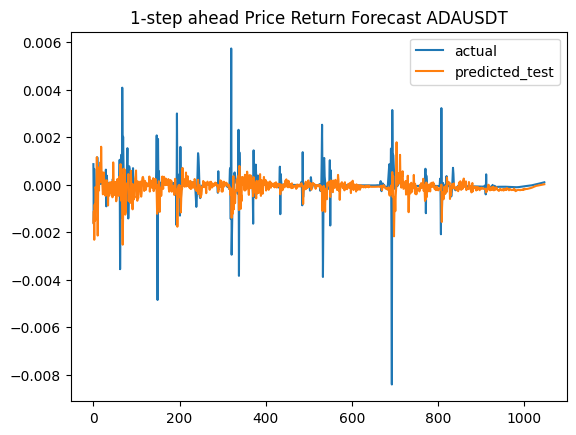

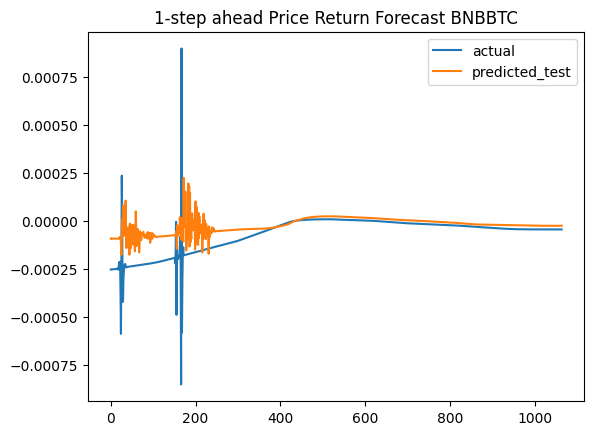

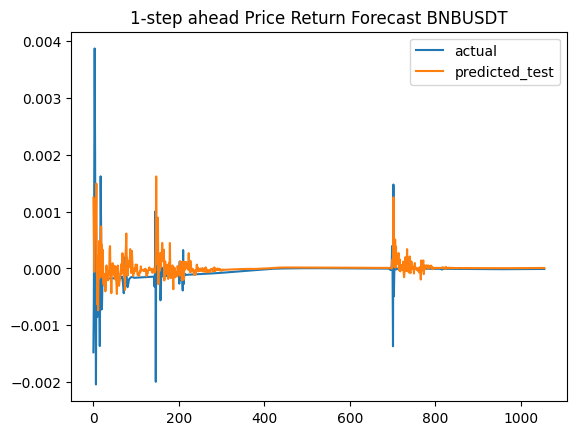

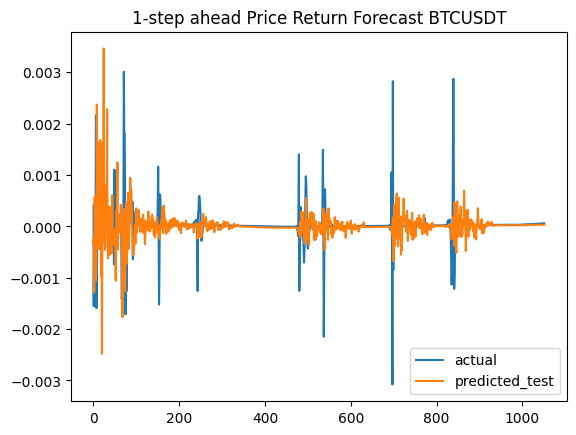

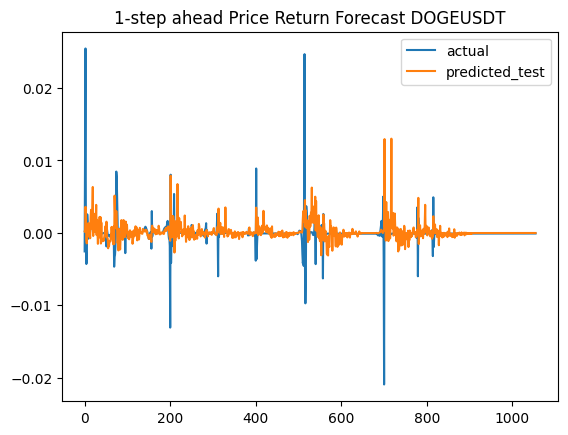

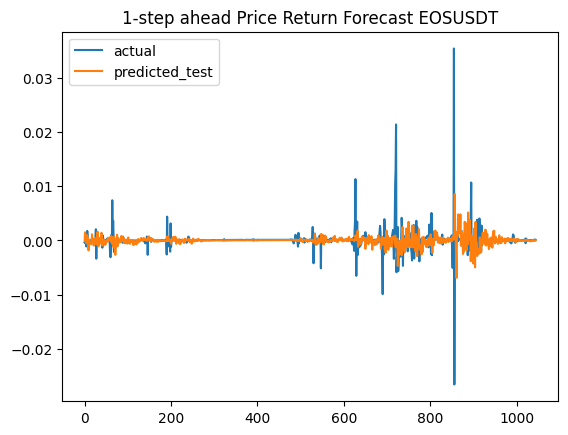

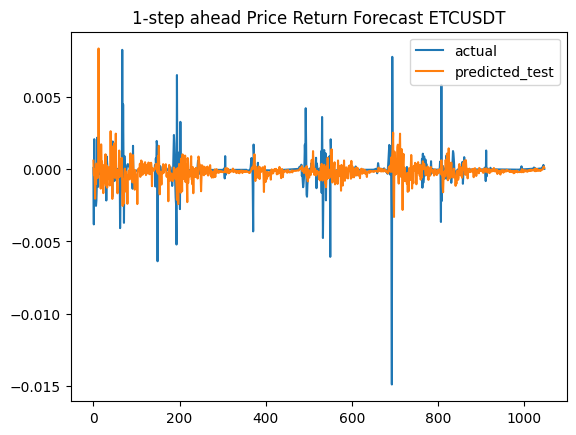

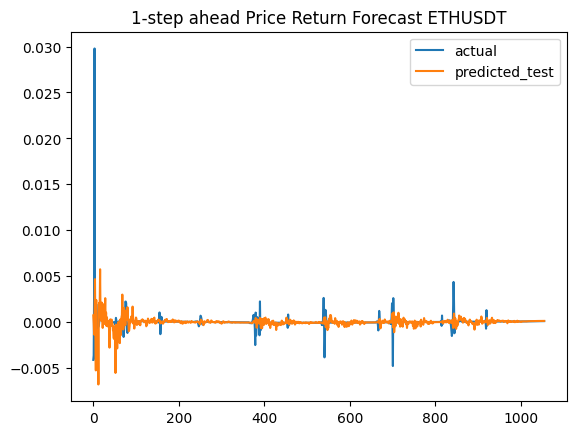

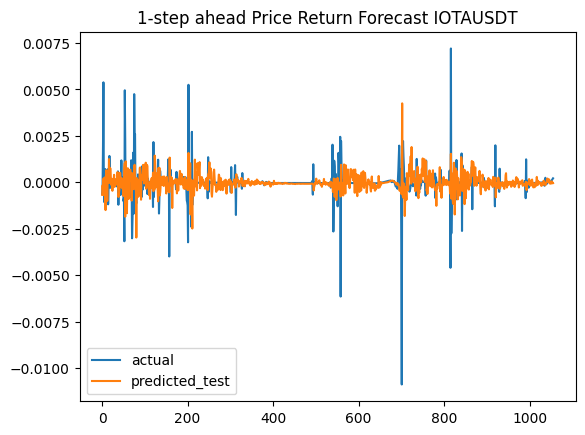

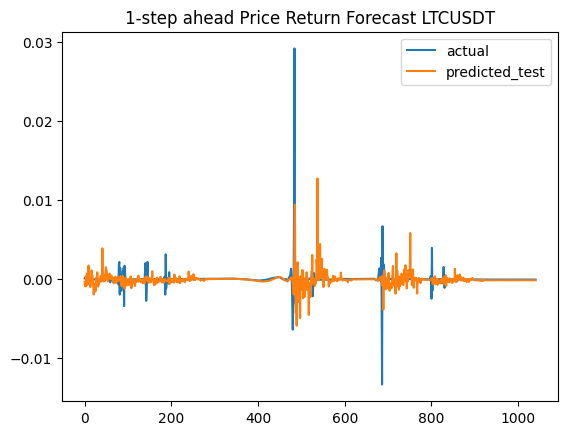

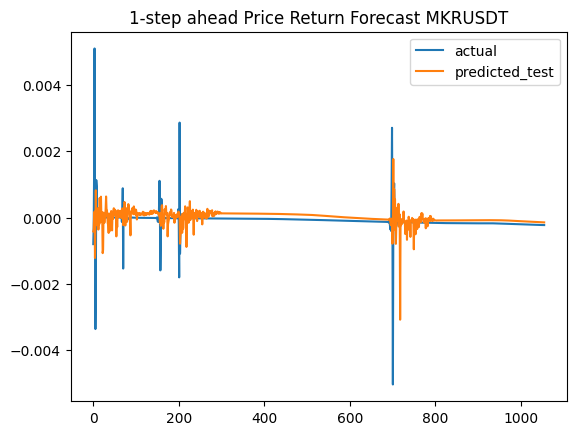

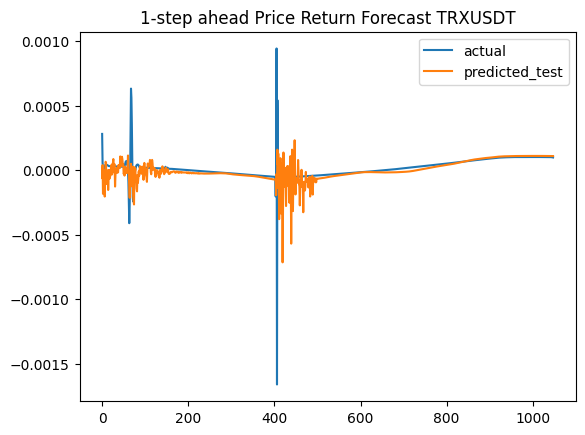

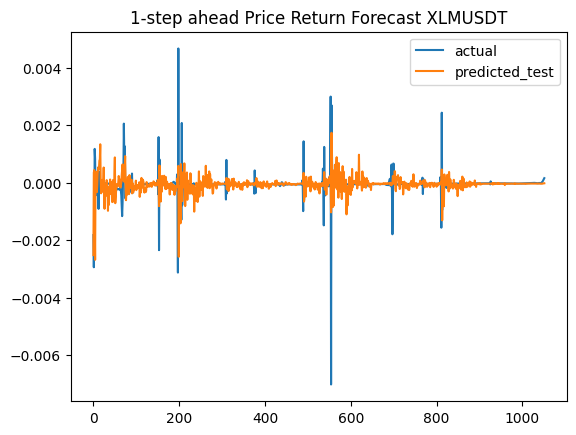

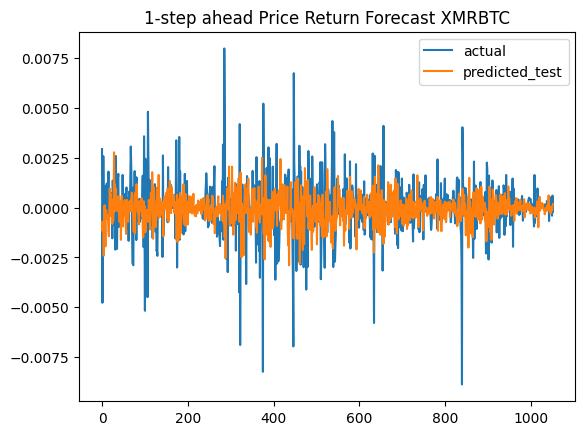

In [15]:
for ticker in df_metric_data['ticker'].unique():

    # original_train = df_test_data[df_test_data['ticker'] == ticker]['original_train'].values
    # forecast_train = df_test_data[df_test_data['ticker'] == ticker]['original_train'].values

    original_test = df_test_data[df_test_data['ticker'] == ticker]['original_test'].values
    forecast_test = df_test_data[df_test_data['ticker'] == ticker]['forecast_test'].values

    # plt.plot(original_train)
    # plt.plot(forecast_train)
    # plt.title(f'Price Return Forecast {ticker}')
    # plt.legend(['actual_train', 'predicted_train'])
    # plt.show()

    plt.plot(original_test)
    plt.plot(forecast_test)
    plt.title(f'1-step ahead Price Return Forecast {ticker}')
    plt.legend(['actual', 'predicted_test'])
    plt.show()


## Training Using Keras Timeseries Generator

In [17]:
def train_tcn_model_generator(train_generator : ks.preprocessing.sequence.TimeseriesGenerator, 
                validation_generator : ks.preprocessing.sequence.TimeseriesGenerator, 
                lag_length : int, 
                epochs: int, 
                verbose : int, 
                n_features: int) -> ks.engine.sequential.Sequential:

        model = Sequential()
        model.add(TCN(input_shape=(lag_length, n_features),
                dilations = [3,4],
                kernel_size = 3,
                use_skip_connections=False,
                use_batch_norm=False,
                use_weight_norm=False,
                use_layer_norm=False
                ))
        model.add(Dense(1, activation='linear')) # https://keras.io/api/layers/activations/
        model.compile(optimizer='adam', loss='mse')

        # Define Early stopping
        early_stop = EarlyStopping(monitor='val_loss',patience=2)

        print('Train...')
        # fit model
        model.fit_generator(train_generator,
                        epochs=epochs,
                        validation_data = validation_generator,
                        callbacks=[early_stop])

        return model

In [ ]:
for ticker in df_prices['ticker'].unique():

    df_temp = df_prices[df_prices['ticker'] == ticker].copy()

    ts = df_temp['denoised_price_returns'].values.reshape(-1, 1)
    
    # Take the max divisible units of the timeseries
    # which can be generated by the selected batch_size
    lag_length = df_temp['pacf_lag'].values[0]
    max_len = int(len(ts)/lag_length) *lag_length
    ts = ts[-max_len:]

    scaler = StandardScaler()
    ts_norm = scaler.fit_transform(ts)

    test_units = int(len(ts) * test_size)
    test_start = int(len(ts) - test_units)

    ts_train = ts_norm[:test_start]
    ts_test = ts_norm[test_start:]

    # let's generate the train/test samples based
    # on the lag_length found in the pacf function
    train_generator = TimeseriesGenerator(ts_train, 
                ts_train, 
                length=lag_length, 
                batch_size=batch_size)

    validation_generator = TimeseriesGenerator(ts_test,
                                ts_test, 
                                length=lag_length, 
                                batch_size=batch_size)

    model = train_tcn_model(train_generator = train_generator, 
                validation_generator = validation_generator,
                lag_length = lag_length, 
                epochs = epochs, 
                verbose = verbose, 
                n_features = n_features)               

    break
    

In [21]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

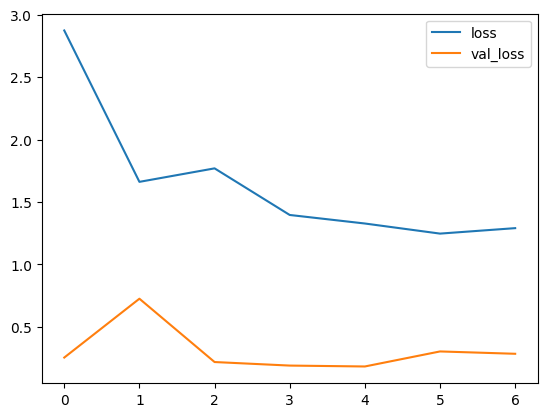

In [23]:
losses.plot()

In [49]:
X, y = validation_generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.03166614 -0.00535597  0.00279834  0.00920996  0.0094896   0.02575185
  0.00212354 -0.11328089  0.20958535 -0.05641729 -0.04792512  0.0558567
 -0.02308513 -0.70856601  1.50564538 -0.52501675 -0.18127407  0.02492101
  0.07179566  0.05757765 -0.10659419  0.08705231 -0.16823831 -0.0282595
 -0.06551691 -0.07570993 -0.03839362  0.00287275  0.0191855   0.01208937
 -0.12444122 -0.08723308 -0.52877577  1.01597739  0.4695933  -0.29325194
 -0.40783344 -0.34676947 -0.13543217  0.19366735 -0.01124008  0.12066791
  0.04575616 -0.02071259 -0.03743254 -0.03407719 -0.0369233  -0.03473202]
Predict this y: 
 [[-0.04293136]]


In [57]:
validation_generator = TimeseriesGenerator(ts_test,
                                ts_test, 
                                length=lag_length, 
                                batch_size=batch_size)
                                
# Code to create Multi-step ahead forecast
test_predictions = []

for X, y in validation_generator:
    
    X = np.array(X.flatten()).reshape((1, lag_length, n_features))

    #print("Predicting , ", y, "given, ", X)

    # Get prediction
    pred = model.predict(current_batch, verbose=0)[0]
    
    # store prediction
    test_predictions.append(pred) 

In [54]:
# # Code to create Multi-step ahead forecast
# test_predictions = []

# first_eval_batch = ts_train[-lag_length:]
# current_batch = first_eval_batch.reshape((1, lag_length, n_features))
# periods = len(ts_test)

# for i in range(periods):
    
#     # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#     current_pred = model.predict(current_batch, verbose=0)[0]
    
#     # store prediction
#     test_predictions.append(current_pred) 
    
#     # update batch to now include prediction and drop first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [58]:
len(true_predictions)

528

In [298]:
true_predictions = scaler.inverse_transform(test_predictions)

# IGNORE WARNINGS
test = pd.DataFrame()
test['price_return'] = ts[test_start:].reshape(1,-1)[0]
test['Predictions'] = true_predictions

mape = mean_absolute_percentage_error(test['price_return'].values, test['Predictions'].values)

print(" MAPE is: " , np.round(mape, 2)*100, "% for one step ahead forecast" )

<AxesSubplot: >

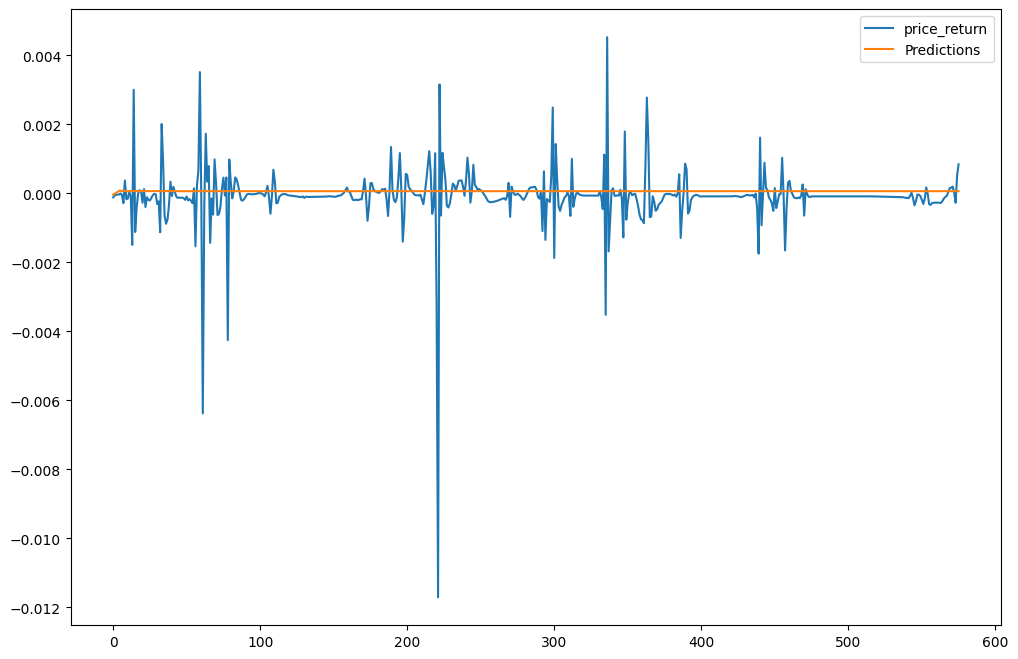

In [42]:
test.plot(figsize=(12,8))